# GAN - Generative Adversarial Networks

In [1]:
import os
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

## What is Generative Adversarial Networks?

Generative Adversarial Networks (GANs) були вперше представлені в 2014 році і відтоді цей напрямок відкрив нову область дослідження.

Протягом кількох років дослідницьке співтовариство придумало багато робіт на цю тему, деякі з яких мають дуже цікаві назви. У нас є CycleGAN, потім BiCycleGAN, потім ReCycleGAN і так далі.

З винаходом GAN генеративні моделі почали демонструвати багатообіцяючі результати у створенні реалістичних зображень. GANs показали величезний успіх у комп’ютерному зорі. Останнім часом він також почав показувати багатообіцяючі результати в аудіо та тексті.

Деякі з найпопулярніших форм GAN:
- Перетворення зображення з одного домену в інший (CycleGAN),
- Створення зображення з текстового опису (текст в зображення),
- Створення зображень із дуже високою роздільною здатністю (ProgressiveGAN) та багато іншого.


Генеративне моделювання — це неконтрольоване навчальне завдання в машинному навчанні, яке передбачає автоматичне виявлення та вивчення закономірностей або закономірностей у вхідних даних таким чином, щоб модель могла використовуватися для генерування або виведення нових прикладів, які ймовірно могли бути взяті з вихідного набору даних.

GAN — це розумний спосіб навчання генеративної моделі, створюючи проблему як проблему навчання під наглядом за допомогою двох підмоделей: моделі генератора, яку ми навчаємо генерувати нові приклади, і моделі дискримінатора, яка намагається класифікувати приклади як реальні або підроблені (фейкові). Дві моделі тренуються разом у змагальній грі, доки модель дискримінатора не буде обманута приблизно в половині випадків, тобто модель генератора має генерувати правдоподібні приклади.


<center><img src="assets/gan_principle.webp" title="Roles of the generator and the discriminator. Source: Stanford CS231n"/></center>

Принцип полягає в грі двох гравців: нейронної мережі, яка називається генератором, і нейронної мережі, яка називається дискримінатором. **Генератор** намагається обдурити дискримінатор, генеруючи фейкові зображення, а **дискримінатор** намагається відрізнити справжні зображення від підроблених. Отже, ми розуміємо термін «змагальний» у «генеративних змагальних мережах».

Під час навчання генератор поступово стає кращим у створенні зображень, які виглядають справжніми, тоді як дискримінатор стає кращим у їх розрізненні. Процес досягає рівноваги, коли дискримінатор більше не може відрізнити справжні зображення від фейкових. Таким чином, якщо дискримінатор добре навчений і генератору вдається генерувати реальні зображення, які вводять дискримінатора в оману, тоді ми маємо хорошу генеративну модель: ми генеруємо зображення, які виглядають як навчальний набір.

<center><img src="assets/gan_training.webp" title="Generator and discriminator training."/></center>


Після цього етапу навчання нам потрібен лише генератор для генерації нових реалістичних даних. Нам більше не потрібен дискримінатор. Зверніть увагу, що випадковий шум гарантує, що генератор не завжди створює однакове зображення (що може ввести в оману дискримінатор).

GAN — це захоплююча галузь, яка швидко змінюється, і вона реалізує перспективні генеративні моделі завдяки своїй здатності генерувати реалістичні приклади в ряді проблемних областей, особливо в задачах трансферу стилю зображень, таких як трансфер фотографій літа на зиму чи дня до ночі, а також у створенні фотореалістичних фотографій об’єктів, сцен і людей, які навіть ми не завжди можемо сказати, що вони підроблені.

## Vanilla GAN

Існує 2 типи моделей у контексті навчання: генеративна та дискримінатор моделі. Дискримінатор моделі в основному використовуються для вирішення завдання класифікації, коли модель зазвичай дізнається межу рішення, щоб передбачити, до якого класу належить точка даних. З іншого боку, генеративні моделі в основному використовуються для створення синтетичних точок даних, які відповідають такому ж розподілу ймовірностей, що й розподіл навчальних даних.

<!-- https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet -->
<div class="alert alert-block alert-info">
Основна мета генеративної моделі — дізнатися невідомий розподіл ймовірностей генеральної сукупності, з якої відбираються навчальні спостереження.<br> Після успішного навчання моделі ви можете взяти нові, «згенеровані» спостереження, які слідують за навчальним розподілом.
</div>

GAN складається з двох незалежних мереж, генератора та дискримінатора.

### Generator Architecture

**Генератор генерує синтетичні зразки з випадковим шумом (вибірка з латентного простору), а дискримінатор є двійковим класифікатором, який розрізняє, чи є вхідний зразок справжнім (виведення скалярного значення 1) чи фальшивим (виведення скалярного значення 0).**

Зразки, створені Генератором, називаються фейковими. Як ви бачите на рис., що коли точка даних із навчального набору даних подається як вхідні дані для дискримінатора, вона називає її реальним зразком, тоді як інша точка даних називається фейком, коли її генерує генератор.

<center><img src="assets/vanila_gan.webp" title="Generator and Discriminator as GAN building blocks"/></center>

### Discriminator Architecture

Дискримінатор хоче виконувати свою роботу найкращим чином. **Коли фальшивий зразок (який генерує Генератор) передається Дискримінатору, він хоче назвати його фейковим, але Генератор хоче згенерувати зразки таким чином, щоб Дискримінатор зробив помилку, назвавши фейковий справжнім. У певному сенсі Генератор намагається обдурити Дискримінатора.**

<center><img src="assets/vanila_gan_2.webp" title="Generator and Discriminator as GAN building blocks"/></center>

### Optimization

Генератор $G$ і дискримінатор $D$ спільно навчаються в формулюванні min-max гри для двох гравців. <br> Min-max цільова функція:

$$ \underset{\theta_g}{\min} \underset{\theta_d}{\max} \big[ \mathbb{E}_{x \sim p_{\textit{data}}} \log D_{\theta_d}(x) + \mathbb{E}_{z \sim p(z)} \log \big( 1 - D_{\theta_d}(G_{\theta_g}(z)) \big)   \big] $$

де $\theta_g$ — параметри $G$, а $\theta_d$ — параметри $D$.

Далі ми називаємо $D_{\theta_d}$ просто $D$, а $G_{\theta_g}$ — $G$.

За визначенням, $D$ виводить ймовірність реального зображення в інтервалі $[0, 1]$ (фейкові чи не фейкові дані).

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super().__init__()

        self.gen = nn.Sequential(
            self.get_generator_block(z_dim, hidden_dim),
            self.get_generator_block(hidden_dim, hidden_dim * 2),
            self.get_generator_block(hidden_dim * 2, hidden_dim * 4),
            self.get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )

    def get_generator_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, noise):
        return self.gen(noise)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.get_discriminator_block(im_dim, hidden_dim * 4),
            self.get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            self.get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def get_discriminator_block(self, input_dim, output_dim):
        return nn.Sequential(
             nn.Linear(input_dim, output_dim), 
             nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, image):
        return self.disc(image)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,),(0.5,))
])
to_image = transforms.ToPILImage()

train = MNIST("./data", train=True, download=True, transform=transform)
dataloader = DataLoader(train, batch_size=100, shuffle=True, drop_last=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator(128).to(device)
discriminator = Discriminator().to(device)

gen_optim = optim.Adam(generator.parameters(), lr=1e-4)
disc_optim = optim.Adam(discriminator.parameters(), lr=1e-4)

criterion = nn.BCEWithLogitsLoss()

In [6]:
def train_discriminator(model, loss_fn, optimizer, real_data, fake_data):    
    optimizer.zero_grad()
    
    preds_real = model(real_data)
    loss_real = loss_fn(preds_real, torch.ones_like(preds_real))
    loss_real.backward()
    
    preds_fake = model(fake_data)
    loss_fake = loss_fn(preds_fake, torch.zeros_like(preds_fake))
    loss_fake.backward()

    optimizer.step()

    return (loss_real + loss_fake).item()


def train_generator(model, loss_fn, optimizer, fake_data):
    optimizer.zero_grad()
    
    preds_fake = model(fake_data)
    loss = loss_fn(preds_fake, torch.ones_like(preds_fake))
    loss.backward()
    
    optimizer.step()
    return loss.item()

Epoch   1| generator loss: 5.40342881 discriminator loss: 0.36133205
Epoch   2| generator loss: 4.61318598 discriminator loss: 0.17848531
Epoch   3| generator loss: 6.18262709 discriminator loss: 0.06305150
Epoch   4| generator loss: 6.74336592 discriminator loss: 0.06302282
Epoch   5| generator loss: 6.80148679 discriminator loss: 0.07945141
Epoch   6| generator loss: 5.76743629 discriminator loss: 0.13252643
Epoch   7| generator loss: 4.96232167 discriminator loss: 0.14430706
Epoch   8| generator loss: 4.89671579 discriminator loss: 0.16267428
Epoch   9| generator loss: 4.90690833 discriminator loss: 0.16296072
Epoch  10| generator loss: 4.72970544 discriminator loss: 0.14969387


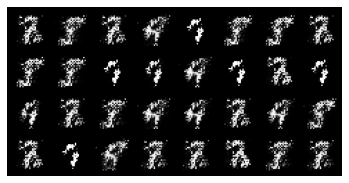

Epoch  11| generator loss: 4.65615103 discriminator loss: 0.15588209
Epoch  12| generator loss: 4.52846233 discriminator loss: 0.18266271
Epoch  13| generator loss: 4.59916899 discriminator loss: 0.15032409
Epoch  14| generator loss: 4.50900039 discriminator loss: 0.15139133
Epoch  15| generator loss: 4.69971915 discriminator loss: 0.13968325
Epoch  16| generator loss: 4.51175721 discriminator loss: 0.15706164
Epoch  17| generator loss: 4.68712436 discriminator loss: 0.13645655
Epoch  18| generator loss: 4.81531616 discriminator loss: 0.12628644
Epoch  19| generator loss: 4.87288257 discriminator loss: 0.13221204
Epoch  20| generator loss: 4.31815902 discriminator loss: 0.17723952


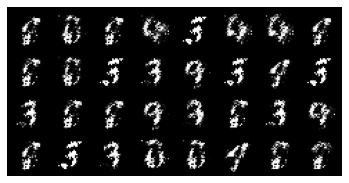

Epoch  21| generator loss: 4.60268271 discriminator loss: 0.14155280
Epoch  22| generator loss: 4.54433992 discriminator loss: 0.16244533
Epoch  23| generator loss: 4.39320696 discriminator loss: 0.16042225
Epoch  24| generator loss: 4.67213628 discriminator loss: 0.14202914
Epoch  25| generator loss: 4.51763471 discriminator loss: 0.15957841
Epoch  26| generator loss: 4.70889622 discriminator loss: 0.13975394
Epoch  27| generator loss: 4.30825579 discriminator loss: 0.18081914
Epoch  28| generator loss: 4.61854153 discriminator loss: 0.14458814
Epoch  29| generator loss: 5.14240968 discriminator loss: 0.10839289
Epoch  30| generator loss: 4.54222847 discriminator loss: 0.14288138


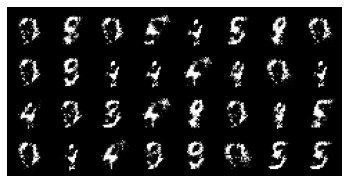

Epoch  31| generator loss: 4.77047313 discriminator loss: 0.15078109
Epoch  32| generator loss: 5.23169768 discriminator loss: 0.12304180
Epoch  33| generator loss: 5.27523260 discriminator loss: 0.10546420
Epoch  34| generator loss: 5.21982422 discriminator loss: 0.11418984
Epoch  35| generator loss: 4.91473196 discriminator loss: 0.12644355
Epoch  36| generator loss: 4.80483507 discriminator loss: 0.12649517
Epoch  37| generator loss: 4.87383296 discriminator loss: 0.13093027
Epoch  38| generator loss: 5.02001716 discriminator loss: 0.13216019
Epoch  39| generator loss: 4.61930139 discriminator loss: 0.14329051
Epoch  40| generator loss: 5.02268462 discriminator loss: 0.13054376


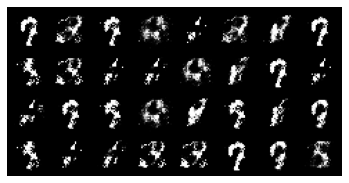

Epoch  41| generator loss: 4.81645642 discriminator loss: 0.14190933
Epoch  42| generator loss: 4.69166183 discriminator loss: 0.15795988
Epoch  43| generator loss: 4.50931296 discriminator loss: 0.17937996
Epoch  44| generator loss: 4.57874869 discriminator loss: 0.15254883
Epoch  45| generator loss: 4.88478359 discriminator loss: 0.13433799
Epoch  46| generator loss: 4.63531570 discriminator loss: 0.15335299
Epoch  47| generator loss: 5.16333681 discriminator loss: 0.12513755
Epoch  48| generator loss: 4.63092580 discriminator loss: 0.15286807
Epoch  49| generator loss: 4.63788631 discriminator loss: 0.15403201
Epoch  50| generator loss: 4.99780581 discriminator loss: 0.14035461


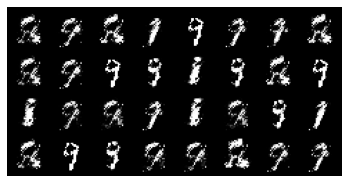

Epoch  51| generator loss: 4.83322803 discriminator loss: 0.13052916
Epoch  52| generator loss: 4.85523678 discriminator loss: 0.12971650
Epoch  53| generator loss: 4.79484660 discriminator loss: 0.13863735
Epoch  54| generator loss: 5.08403342 discriminator loss: 0.12449984
Epoch  55| generator loss: 4.64241572 discriminator loss: 0.16763765
Epoch  56| generator loss: 4.69235893 discriminator loss: 0.14978340
Epoch  57| generator loss: 4.77632630 discriminator loss: 0.13573211
Epoch  58| generator loss: 4.42263752 discriminator loss: 0.14886351
Epoch  59| generator loss: 5.07643437 discriminator loss: 0.15646702
Epoch  60| generator loss: 4.82177235 discriminator loss: 0.14096493


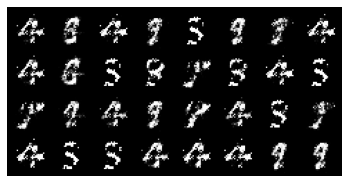

Epoch  61| generator loss: 4.49605349 discriminator loss: 0.17278655
Epoch  62| generator loss: 4.26730920 discriminator loss: 0.16769306
Epoch  63| generator loss: 4.46997059 discriminator loss: 0.16125602
Epoch  64| generator loss: 4.55976367 discriminator loss: 0.15889169
Epoch  65| generator loss: 4.20149130 discriminator loss: 0.19830831
Epoch  66| generator loss: 4.20427089 discriminator loss: 0.18966639
Epoch  67| generator loss: 4.18389732 discriminator loss: 0.18903719
Epoch  68| generator loss: 4.70098140 discriminator loss: 0.14428426
Epoch  69| generator loss: 4.36982689 discriminator loss: 0.18187721
Epoch  70| generator loss: 4.33656639 discriminator loss: 0.18130394


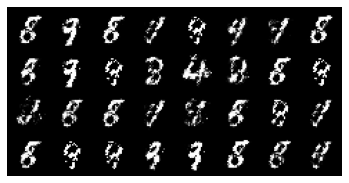

Epoch  71| generator loss: 3.95450512 discriminator loss: 0.21721362
Epoch  72| generator loss: 3.94252833 discriminator loss: 0.21169333
Epoch  73| generator loss: 3.81689852 discriminator loss: 0.22746681
Epoch  74| generator loss: 3.89871843 discriminator loss: 0.22967559
Epoch  75| generator loss: 3.70383239 discriminator loss: 0.23849483
Epoch  76| generator loss: 3.57606342 discriminator loss: 0.27536694
Epoch  77| generator loss: 3.72926058 discriminator loss: 0.22874032
Epoch  78| generator loss: 4.11845279 discriminator loss: 0.23177877
Epoch  79| generator loss: 3.71286028 discriminator loss: 0.25510712
Epoch  80| generator loss: 3.58769251 discriminator loss: 0.26385305


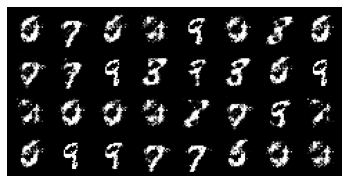

Epoch  81| generator loss: 4.08246300 discriminator loss: 0.20573227
Epoch  82| generator loss: 3.81208493 discriminator loss: 0.23522619
Epoch  83| generator loss: 3.77945479 discriminator loss: 0.24387692
Epoch  84| generator loss: 3.56618511 discriminator loss: 0.27319116
Epoch  85| generator loss: 3.55600230 discriminator loss: 0.23400107
Epoch  86| generator loss: 3.80079367 discriminator loss: 0.27677546
Epoch  87| generator loss: 3.80327010 discriminator loss: 0.21651542
Epoch  88| generator loss: 3.57144012 discriminator loss: 0.26260863
Epoch  89| generator loss: 3.32465370 discriminator loss: 0.30499248
Epoch  90| generator loss: 3.36164622 discriminator loss: 0.30002947


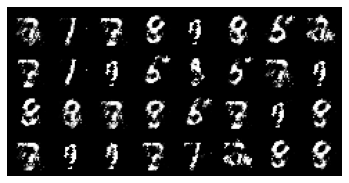

Epoch  91| generator loss: 3.48502103 discriminator loss: 0.28502142
Epoch  92| generator loss: 3.35577373 discriminator loss: 0.29662514
Epoch  93| generator loss: 3.24224822 discriminator loss: 0.32749809
Epoch  94| generator loss: 3.25394826 discriminator loss: 0.31199851
Epoch  95| generator loss: 3.36989218 discriminator loss: 0.28145585
Epoch  96| generator loss: 3.15429118 discriminator loss: 0.32450536
Epoch  97| generator loss: 3.20826021 discriminator loss: 0.34150070
Epoch  98| generator loss: 3.10247088 discriminator loss: 0.33083387
Epoch  99| generator loss: 3.30724260 discriminator loss: 0.32183144
Epoch 100| generator loss: 2.97543344 discriminator loss: 0.35058281


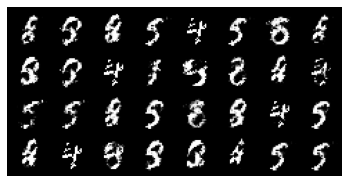

Epoch 101| generator loss: 3.11511634 discriminator loss: 0.36858931
Epoch 102| generator loss: 3.07666474 discriminator loss: 0.34387703
Epoch 103| generator loss: 3.02478727 discriminator loss: 0.34921901
Epoch 104| generator loss: 3.00871490 discriminator loss: 0.34924195
Epoch 105| generator loss: 3.17493253 discriminator loss: 0.31965011
Epoch 106| generator loss: 2.97172551 discriminator loss: 0.39743581
Epoch 107| generator loss: 2.73250256 discriminator loss: 0.42239560
Epoch 108| generator loss: 2.84440666 discriminator loss: 0.37736935
Epoch 109| generator loss: 3.14415777 discriminator loss: 0.34470907
Epoch 110| generator loss: 3.09762015 discriminator loss: 0.37595594


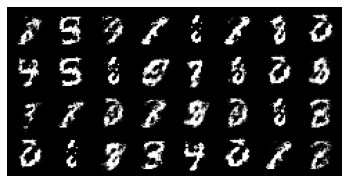

Epoch 111| generator loss: 3.02011908 discriminator loss: 0.33622108
Epoch 112| generator loss: 3.18980336 discriminator loss: 0.32756380
Epoch 113| generator loss: 2.88792457 discriminator loss: 0.40490779
Epoch 114| generator loss: 2.93077446 discriminator loss: 0.39501614
Epoch 115| generator loss: 3.11089826 discriminator loss: 0.34127876
Epoch 116| generator loss: 2.90841451 discriminator loss: 0.36118415
Epoch 117| generator loss: 2.91533452 discriminator loss: 0.39395022
Epoch 118| generator loss: 2.79768894 discriminator loss: 0.42313860
Epoch 119| generator loss: 2.81485119 discriminator loss: 0.42270320
Epoch 120| generator loss: 2.56439583 discriminator loss: 0.45156779


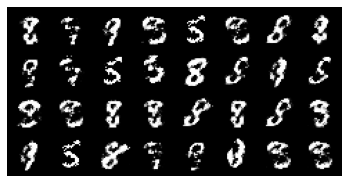

Epoch 121| generator loss: 2.52715750 discriminator loss: 0.48728290
Epoch 122| generator loss: 2.41194614 discriminator loss: 0.49251579
Epoch 123| generator loss: 2.75707316 discriminator loss: 0.42568080
Epoch 124| generator loss: 2.78367155 discriminator loss: 0.40466476
Epoch 125| generator loss: 2.85972995 discriminator loss: 0.38118740
Epoch 126| generator loss: 2.78083662 discriminator loss: 0.45145051
Epoch 127| generator loss: 2.61416461 discriminator loss: 0.44689763
Epoch 128| generator loss: 2.74475133 discriminator loss: 0.40517708
Epoch 129| generator loss: 2.60596216 discriminator loss: 0.46213579
Epoch 130| generator loss: 2.46651701 discriminator loss: 0.50076595


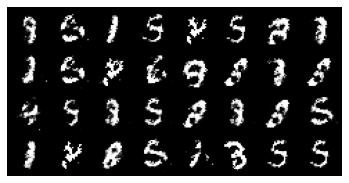

Epoch 131| generator loss: 2.61269885 discriminator loss: 0.46534177
Epoch 132| generator loss: 2.54027327 discriminator loss: 0.45089256
Epoch 133| generator loss: 2.73278936 discriminator loss: 0.42846552
Epoch 134| generator loss: 2.57238652 discriminator loss: 0.44409482
Epoch 135| generator loss: 2.50848401 discriminator loss: 0.47066841
Epoch 136| generator loss: 2.62868607 discriminator loss: 0.47362830
Epoch 137| generator loss: 2.45441900 discriminator loss: 0.48761388
Epoch 138| generator loss: 2.34622103 discriminator loss: 0.52169498
Epoch 139| generator loss: 2.62484345 discriminator loss: 0.45681429
Epoch 140| generator loss: 2.59663954 discriminator loss: 0.42486264


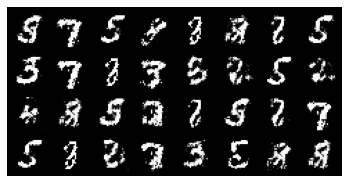

Epoch 141| generator loss: 2.52929175 discriminator loss: 0.46835090
Epoch 142| generator loss: 2.46492624 discriminator loss: 0.46601660
Epoch 143| generator loss: 2.44998816 discriminator loss: 0.51480567
Epoch 144| generator loss: 2.54176886 discriminator loss: 0.46497215
Epoch 145| generator loss: 2.74040273 discriminator loss: 0.43535142
Epoch 146| generator loss: 2.68212023 discriminator loss: 0.41103801
Epoch 147| generator loss: 2.87718032 discriminator loss: 0.41942016
Epoch 148| generator loss: 2.74567145 discriminator loss: 0.39775967
Epoch 149| generator loss: 3.06001799 discriminator loss: 0.38578356
Epoch 150| generator loss: 2.78361430 discriminator loss: 0.39733470


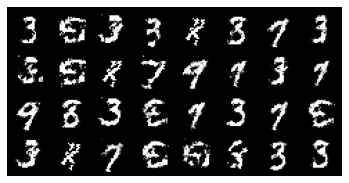

Epoch 151| generator loss: 2.82317777 discriminator loss: 0.42708717
Epoch 152| generator loss: 2.44923834 discriminator loss: 0.49322478
Epoch 153| generator loss: 2.56925809 discriminator loss: 0.46098907
Epoch 154| generator loss: 2.80532498 discriminator loss: 0.42284196
Epoch 155| generator loss: 2.84297828 discriminator loss: 0.40186473
Epoch 156| generator loss: 2.79570427 discriminator loss: 0.41578277
Epoch 157| generator loss: 2.63172561 discriminator loss: 0.44218264
Epoch 158| generator loss: 2.79021203 discriminator loss: 0.40684348
Epoch 159| generator loss: 2.84893257 discriminator loss: 0.40956684
Epoch 160| generator loss: 2.70333767 discriminator loss: 0.41787465


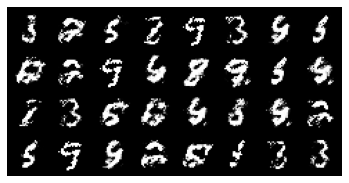

Epoch 161| generator loss: 2.77682468 discriminator loss: 0.39964910
Epoch 162| generator loss: 2.78376447 discriminator loss: 0.42028537
Epoch 163| generator loss: 2.62949188 discriminator loss: 0.43415494
Epoch 164| generator loss: 2.64794325 discriminator loss: 0.45592657
Epoch 165| generator loss: 2.64291924 discriminator loss: 0.46789068
Epoch 166| generator loss: 2.74164425 discriminator loss: 0.43517060
Epoch 167| generator loss: 2.66299690 discriminator loss: 0.45343059
Epoch 168| generator loss: 2.62966445 discriminator loss: 0.45444001
Epoch 169| generator loss: 2.60239777 discriminator loss: 0.46495789
Epoch 170| generator loss: 2.49981038 discriminator loss: 0.49866135


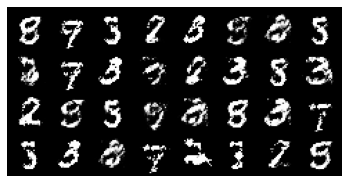

Epoch 171| generator loss: 2.49724193 discriminator loss: 0.49248152
Epoch 172| generator loss: 2.52367206 discriminator loss: 0.46880097
Epoch 173| generator loss: 2.64537482 discriminator loss: 0.45203397
Epoch 174| generator loss: 2.58572561 discriminator loss: 0.46780920
Epoch 175| generator loss: 2.55802785 discriminator loss: 0.48008156
Epoch 176| generator loss: 2.60363182 discriminator loss: 0.44427719
Epoch 177| generator loss: 2.53911358 discriminator loss: 0.46693582
Epoch 178| generator loss: 2.47531824 discriminator loss: 0.51151860
Epoch 179| generator loss: 2.50064688 discriminator loss: 0.46338481
Epoch 180| generator loss: 2.71619475 discriminator loss: 0.44115351


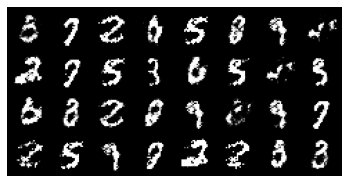

Epoch 181| generator loss: 2.57844460 discriminator loss: 0.46840798
Epoch 182| generator loss: 2.43736520 discriminator loss: 0.51184777
Epoch 183| generator loss: 2.46291527 discriminator loss: 0.48271293
Epoch 184| generator loss: 2.51251411 discriminator loss: 0.48334598
Epoch 185| generator loss: 2.45856052 discriminator loss: 0.48026925
Epoch 186| generator loss: 2.52437931 discriminator loss: 0.47203406
Epoch 187| generator loss: 2.56291913 discriminator loss: 0.48042359
Epoch 188| generator loss: 2.54399223 discriminator loss: 0.47689135
Epoch 189| generator loss: 2.52062005 discriminator loss: 0.49012273
Epoch 190| generator loss: 2.56414841 discriminator loss: 0.45132172


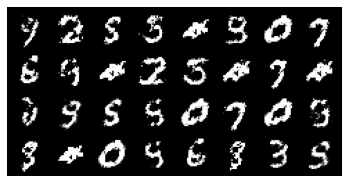

Epoch 191| generator loss: 2.67135356 discriminator loss: 0.46194455
Epoch 192| generator loss: 2.50461846 discriminator loss: 0.47164521
Epoch 193| generator loss: 2.52656443 discriminator loss: 0.48955554
Epoch 194| generator loss: 2.53817604 discriminator loss: 0.47944421
Epoch 195| generator loss: 2.59306875 discriminator loss: 0.47174478
Epoch 196| generator loss: 2.60035040 discriminator loss: 0.45853742
Epoch 197| generator loss: 2.61245053 discriminator loss: 0.45645488
Epoch 198| generator loss: 2.72756843 discriminator loss: 0.45569364
Epoch 199| generator loss: 2.59465976 discriminator loss: 0.48242174
Epoch 200| generator loss: 2.60935126 discriminator loss: 0.44172273


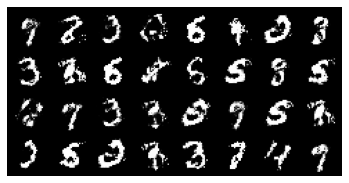

Epoch 201| generator loss: 2.45068704 discriminator loss: 0.48467417
Epoch 202| generator loss: 2.52152205 discriminator loss: 0.46788658
Epoch 203| generator loss: 2.63381494 discriminator loss: 0.45661970
Epoch 204| generator loss: 2.67307985 discriminator loss: 0.46030909
Epoch 205| generator loss: 2.46500288 discriminator loss: 0.49184927
Epoch 206| generator loss: 2.56576603 discriminator loss: 0.47103298
Epoch 207| generator loss: 2.68090544 discriminator loss: 0.44128105
Epoch 208| generator loss: 2.80933356 discriminator loss: 0.39564247
Epoch 209| generator loss: 2.53644297 discriminator loss: 0.47370836
Epoch 210| generator loss: 2.50882747 discriminator loss: 0.48263988


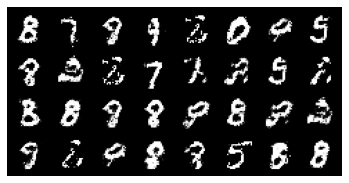

Epoch 211| generator loss: 2.52329537 discriminator loss: 0.49446370
Epoch 212| generator loss: 2.53649593 discriminator loss: 0.48411691
Epoch 213| generator loss: 2.44849390 discriminator loss: 0.48864818
Epoch 214| generator loss: 2.40796169 discriminator loss: 0.50018273
Epoch 215| generator loss: 2.58084381 discriminator loss: 0.45558353
Epoch 216| generator loss: 2.44042373 discriminator loss: 0.47341450
Epoch 217| generator loss: 2.87971578 discriminator loss: 0.40627233
Epoch 218| generator loss: 2.66083850 discriminator loss: 0.45147467
Epoch 219| generator loss: 2.59049447 discriminator loss: 0.46012495
Epoch 220| generator loss: 2.64444331 discriminator loss: 0.42467765


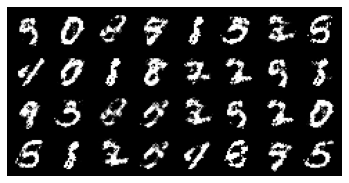

Epoch 221| generator loss: 2.72833988 discriminator loss: 0.42512458
Epoch 222| generator loss: 2.59779960 discriminator loss: 0.44061560
Epoch 223| generator loss: 2.59402359 discriminator loss: 0.45976544
Epoch 224| generator loss: 2.74685008 discriminator loss: 0.41936567
Epoch 225| generator loss: 2.58632311 discriminator loss: 0.45133350
Epoch 226| generator loss: 2.48535304 discriminator loss: 0.49830953
Epoch 227| generator loss: 2.41164095 discriminator loss: 0.49861454
Epoch 228| generator loss: 2.47661344 discriminator loss: 0.50096701
Epoch 229| generator loss: 2.50585736 discriminator loss: 0.47427500
Epoch 230| generator loss: 2.55180378 discriminator loss: 0.50068266


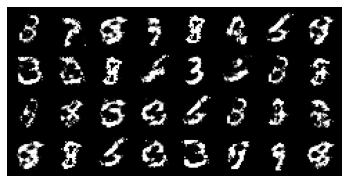

Epoch 231| generator loss: 2.41922747 discriminator loss: 0.48232033
Epoch 232| generator loss: 2.44351000 discriminator loss: 0.48119251
Epoch 233| generator loss: 2.57864930 discriminator loss: 0.48852557
Epoch 234| generator loss: 2.52515163 discriminator loss: 0.50123346
Epoch 235| generator loss: 2.60188211 discriminator loss: 0.45463968
Epoch 236| generator loss: 2.55042809 discriminator loss: 0.44899321
Epoch 237| generator loss: 2.50746490 discriminator loss: 0.48635008
Epoch 238| generator loss: 2.39662495 discriminator loss: 0.49838346
Epoch 239| generator loss: 2.36816003 discriminator loss: 0.51708939
Epoch 240| generator loss: 2.38333271 discriminator loss: 0.52146154


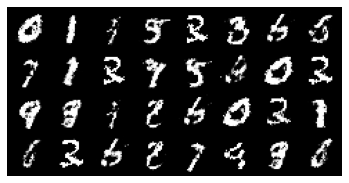

Epoch 241| generator loss: 2.38954122 discriminator loss: 0.54710335
Epoch 242| generator loss: 2.56440425 discriminator loss: 0.46571477
Epoch 243| generator loss: 2.48257224 discriminator loss: 0.48740500
Epoch 244| generator loss: 2.24288919 discriminator loss: 0.53989893
Epoch 245| generator loss: 2.20992579 discriminator loss: 0.53412589
Epoch 246| generator loss: 2.41602690 discriminator loss: 0.51420765
Epoch 247| generator loss: 2.39280863 discriminator loss: 0.50777541
Epoch 248| generator loss: 2.32906858 discriminator loss: 0.51526588
Epoch 249| generator loss: 2.38085459 discriminator loss: 0.51686018
Epoch 250| generator loss: 2.29693605 discriminator loss: 0.51886082


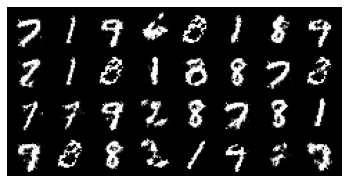

In [7]:
num_epochs = 250
k = 1
test_noise = torch.randn(32, 128).to(device)

generator.train()
discriminator.train()

g_losses, d_losses = [], []

for epoch in range(num_epochs):
    g_loss, d_loss = 0.0, 0.0
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.view(imgs.size(0), -1)

        for j in range(k):
            fake_data = generator(torch.randn(imgs.size(0), 128, device=device)).detach()
            real_data = imgs.to(device)
            d_loss += train_discriminator(discriminator, criterion, disc_optim, real_data, fake_data)

        fake_data = generator(torch.randn(imgs.size(0), 128, device=device))
        g_loss += train_generator(discriminator, criterion, gen_optim, fake_data)

    g_losses.append(g_loss / i)
    d_losses.append(d_loss / i)
    print("Epoch {:3d}| generator loss: {:.8f} discriminator loss: {:.8f}".format(epoch + 1, g_loss / i, d_loss / i))

    if (epoch + 1) % 10 == 0:
        img = generator(test_noise).view(test_noise.size(0), 1, 28, 28).cpu().detach()
        img = make_grid(img).permute(1, 2, 0)

        plt.imshow(img)
        plt.axis("off")
        plt.show()

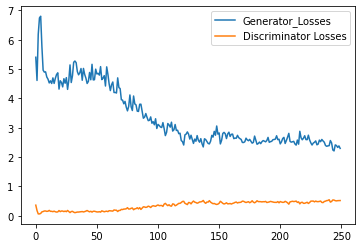

In [8]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()

## Conditional Generative Adversarial Networks (cGAN)

GAN ефективні при синтезі зображень, тобто створенні нових прикладів зображень для цільового набору даних. Деякі набори даних мають додаткову інформацію, таку як мітка класу, і бажано використовувати цю інформацію.

Наприклад, набір даних рукописних цифр MNIST має мітки класу відповідних цілих чисел, набір даних фотографій малих об’єктів CIFAR-10 має мітки класу для відповідних об’єктів на фотографіях, а набір даних одягу Fashion-MNIST має мітки класу для відповідних елементів одяг.

Є дві мотивації для використання інформації мітки класу в моделі GAN.
1. Покращити GAN.
2. Створення цільового зображення.

Додаткову інформацію, яка корелює з вхідними зображеннями, таку як мітки класів, можна використовувати для покращення GAN. Це покращення може бути у формі більш стабільного навчання, швидшого навчання та/або створених зображень кращої якості.

Мітки класів також можна використовувати для навмисного або цілеспрямованого створення зображень певного типу.

Обмеженням моделі GAN є те, що вона може генерувати випадкове зображення з домену. Існує зв’язок між точками в латентному просторі та згенерованими зображеннями, але цей зв’язок складний і його важко відобразити.

З іншого боку, GAN можна навчити таким чином, щоб моделі генератора та дискримінатора залежали від мітки класу. Це означає, що коли навчена модель генератора використовується як окрема модель для створення зображень у домені, можуть бути створені зображення заданого типу або мітки класу.

Їхній підхід продемонстровано в наборі рукописних цифр MNIST, де мітки класів є one-hot encoding і об’єднані з вхідними даними як для моделей генератора, так і для дискримінатора.

На зображенні нижче наведено короткий опис архітектури моделі.

<center><img src="assets/cgan.png" width="600"></center>

In [ ]:
class Discriminator(nn.Module):
    """ It is mainly based on the mobile net network as the backbone network discriminator.

    Args:
        image_size (int): The size of the image. (Default: 28)
        channels (int): The channels of the image. (Default: 1)
        num_classes (int): Number of classes for dataset. (Default: 10)
    """

    def __init__(self, image_size: int = 28, channels: int = 1, num_classes: int = 10) -> None:
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.main = nn.Sequential(
            nn.Linear(channels * image_size * image_size + num_classes, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs: torch.Tensor, labels: list = None) -> torch.Tensor:
        r""" Defines the computation performed at every call.

        Args:
            inputs (tensor): input tensor into the calculation.
            labels (list):  input tensor label.

        Returns:
            A four-dimensional vector (N*C*H*W).
        """
        inputs = torch.flatten(inputs, 1)
        conditional = self.label_embedding(labels)
        conditional_inputs = torch.cat([inputs, conditional], dim=-1)
        out = self.main(conditional_inputs)

        return out

In [10]:
class Generator(nn.Module):
    """ It is mainly based on the mobile net network as the backbone network generator.

    Args:
        image_size (int): The size of the image. (Default: 28)
        channels (int): The channels of the image. (Default: 1)
        num_classes (int): Number of classes for dataset. (Default: 10)
    """

    def __init__(self, image_size: int = 28, channels: int = 1, num_classes: int = 10) -> None:
        super().__init__()
        self.image_size = image_size
        self.channels = channels

        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.hidden_dim = 128
        self.main = nn.Sequential(
            nn.Linear(self.hidden_dim + num_classes, 128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(1024, channels * image_size * image_size),
            nn.Sigmoid()
        )

    def forward(self, inputs: torch.Tensor, labels: list = None) -> torch.Tensor:
        """
        Args:
            inputs (tensor): input tensor into the calculation.
            labels (list):  input tensor label.

        Returns:
            A four-dimensional vector (N*C*H*W).
        """

        conditional_inputs = torch.cat([inputs, self.label_embedding(labels)], dim=-1)
        out = self.main(conditional_inputs)
        out = out.reshape(out.size(0), self.channels, self.image_size, self.image_size)

        return out

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,),(0.5,))
])
to_image = transforms.ToPILImage()

train = MNIST("./data", train=True, download=True, transform=transform)
dataloader = DataLoader(train, batch_size=100, shuffle=True, drop_last=True)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_optim = optim.Adam(generator.parameters(), lr=1e-4)
disc_optim = optim.Adam(discriminator.parameters(), lr=1e-4)

criterion = nn.BCEWithLogitsLoss()

In [13]:
def train_discriminator(model, loss_fn, optimizer, real_data, real_conditions, fake_data, fake_conditions):    
    optimizer.zero_grad()
    
    preds_real = model(real_data, real_conditions)
    loss_real = loss_fn(preds_real, torch.ones_like(preds_real))
    loss_real.backward()
    
    preds_fake = model(fake_data, fake_conditions)
    loss_fake = loss_fn(preds_fake, torch.zeros_like(preds_fake))
    loss_fake.backward()
    
    optimizer.step()
    
    return (loss_real + loss_fake).item()


def train_generator(model, loss_fn, optimizer, fake_data, fake_conditions):
    optimizer.zero_grad()
    
    preds_fake = model(fake_data, fake_conditions)
    loss = loss_fn(preds_fake, torch.ones_like(preds_fake))
    loss.backward()
    
    optimizer.step()
    return loss.item()

Epoch   1| generator loss: 0.59396677 discriminator loss: 1.23986074
Epoch   2| generator loss: 0.66442738 discriminator loss: 1.09277306
Epoch   3| generator loss: 0.68322056 discriminator loss: 1.04249463
Epoch   4| generator loss: 0.68687941 discriminator loss: 1.04108439
Epoch   5| generator loss: 0.68824567 discriminator loss: 1.03929201
Epoch   6| generator loss: 0.67626886 discriminator loss: 1.07373828
Epoch   7| generator loss: 0.68811093 discriminator loss: 1.03742581
Epoch   8| generator loss: 0.68377142 discriminator loss: 1.06147384
Epoch   9| generator loss: 0.67811402 discriminator loss: 1.09159269
Epoch  10| generator loss: 0.67526738 discriminator loss: 1.10313755


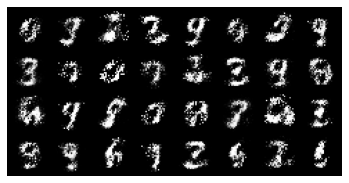

Epoch  11| generator loss: 0.67921323 discriminator loss: 1.08347040
Epoch  12| generator loss: 0.67565816 discriminator loss: 1.11142592
Epoch  13| generator loss: 0.67349661 discriminator loss: 1.11454545
Epoch  14| generator loss: 0.67446238 discriminator loss: 1.10989345
Epoch  15| generator loss: 0.67435346 discriminator loss: 1.11030859
Epoch  16| generator loss: 0.67307859 discriminator loss: 1.11421042
Epoch  17| generator loss: 0.67564362 discriminator loss: 1.11211231
Epoch  18| generator loss: 0.66602689 discriminator loss: 1.15350666
Epoch  19| generator loss: 0.66615040 discriminator loss: 1.17012040
Epoch  20| generator loss: 0.66923140 discriminator loss: 1.14837757


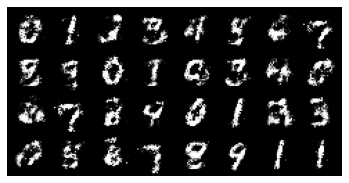

Epoch  21| generator loss: 0.66876825 discriminator loss: 1.14203905
Epoch  22| generator loss: 0.67118560 discriminator loss: 1.12951552
Epoch  23| generator loss: 0.66657243 discriminator loss: 1.14650241
Epoch  24| generator loss: 0.66907811 discriminator loss: 1.13702710
Epoch  25| generator loss: 0.67166325 discriminator loss: 1.12370845
Epoch  26| generator loss: 0.66437439 discriminator loss: 1.15745517
Epoch  27| generator loss: 0.66730419 discriminator loss: 1.14455267
Epoch  28| generator loss: 0.66814578 discriminator loss: 1.15508253
Epoch  29| generator loss: 0.67067764 discriminator loss: 1.13465796
Epoch  30| generator loss: 0.66743982 discriminator loss: 1.14312735


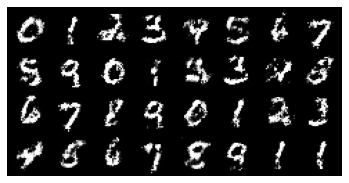

Epoch  31| generator loss: 0.66647238 discriminator loss: 1.15049289
Epoch  32| generator loss: 0.66842671 discriminator loss: 1.15367935
Epoch  33| generator loss: 0.66645149 discriminator loss: 1.15284842
Epoch  34| generator loss: 0.66468507 discriminator loss: 1.16158787
Epoch  35| generator loss: 0.66553593 discriminator loss: 1.16013670
Epoch  36| generator loss: 0.66108144 discriminator loss: 1.17080006
Epoch  37| generator loss: 0.66315345 discriminator loss: 1.16324085
Epoch  38| generator loss: 0.66316077 discriminator loss: 1.18008717
Epoch  39| generator loss: 0.66068102 discriminator loss: 1.17511828
Epoch  40| generator loss: 0.66119967 discriminator loss: 1.17315103


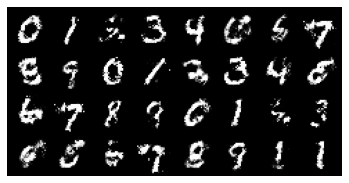

Epoch  41| generator loss: 0.66048495 discriminator loss: 1.18684528
Epoch  42| generator loss: 0.66414421 discriminator loss: 1.16487910
Epoch  43| generator loss: 0.66181261 discriminator loss: 1.18736114
Epoch  44| generator loss: 0.66052337 discriminator loss: 1.17564475
Epoch  45| generator loss: 0.66043981 discriminator loss: 1.18822604
Epoch  46| generator loss: 0.66174951 discriminator loss: 1.18208035
Epoch  47| generator loss: 0.65611572 discriminator loss: 1.20893762
Epoch  48| generator loss: 0.66120617 discriminator loss: 1.18311673
Epoch  49| generator loss: 0.65702829 discriminator loss: 1.20150541
Epoch  50| generator loss: 0.66329557 discriminator loss: 1.17795975


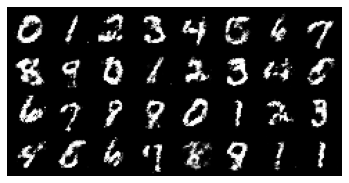

Epoch  51| generator loss: 0.65837832 discriminator loss: 1.19580011
Epoch  52| generator loss: 0.65567683 discriminator loss: 1.20524196
Epoch  53| generator loss: 0.65641565 discriminator loss: 1.21380520
Epoch  54| generator loss: 0.65716228 discriminator loss: 1.20889763
Epoch  55| generator loss: 0.65776146 discriminator loss: 1.20412460
Epoch  56| generator loss: 0.65737081 discriminator loss: 1.21848448
Epoch  57| generator loss: 0.65569717 discriminator loss: 1.22327852
Epoch  58| generator loss: 0.65616906 discriminator loss: 1.22074164
Epoch  59| generator loss: 0.65184935 discriminator loss: 1.22505828
Epoch  60| generator loss: 0.65444713 discriminator loss: 1.21482955


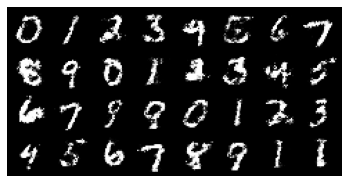

Epoch  61| generator loss: 0.65650767 discriminator loss: 1.23064372
Epoch  62| generator loss: 0.65503297 discriminator loss: 1.21680829
Epoch  63| generator loss: 0.65672271 discriminator loss: 1.20951333
Epoch  64| generator loss: 0.65252628 discriminator loss: 1.22753696
Epoch  65| generator loss: 0.65437992 discriminator loss: 1.23752593
Epoch  66| generator loss: 0.65413640 discriminator loss: 1.22460801
Epoch  67| generator loss: 0.65114032 discriminator loss: 1.24507080
Epoch  68| generator loss: 0.65602957 discriminator loss: 1.23233277
Epoch  69| generator loss: 0.65299419 discriminator loss: 1.22766106
Epoch  70| generator loss: 0.65177367 discriminator loss: 1.24287741


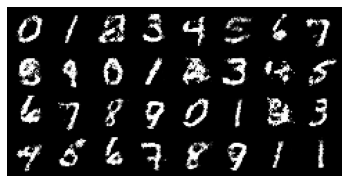

Epoch  71| generator loss: 0.65199642 discriminator loss: 1.24462923
Epoch  72| generator loss: 0.65336186 discriminator loss: 1.24498327
Epoch  73| generator loss: 0.65170701 discriminator loss: 1.24606245
Epoch  74| generator loss: 0.64842401 discriminator loss: 1.24749663
Epoch  75| generator loss: 0.65352948 discriminator loss: 1.25585660
Epoch  76| generator loss: 0.64976230 discriminator loss: 1.24078885
Epoch  77| generator loss: 0.64976957 discriminator loss: 1.25862323
Epoch  78| generator loss: 0.65427247 discriminator loss: 1.24281877
Epoch  79| generator loss: 0.65019072 discriminator loss: 1.25826831
Epoch  80| generator loss: 0.64950625 discriminator loss: 1.26558200


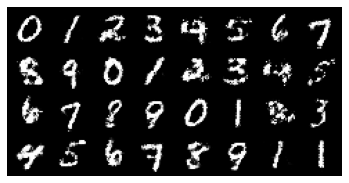

Epoch  81| generator loss: 0.65021134 discriminator loss: 1.27181517
Epoch  82| generator loss: 0.65143507 discriminator loss: 1.26483536
Epoch  83| generator loss: 0.64898713 discriminator loss: 1.25595225
Epoch  84| generator loss: 0.65252232 discriminator loss: 1.27293674
Epoch  85| generator loss: 0.65014966 discriminator loss: 1.26205220
Epoch  86| generator loss: 0.64887915 discriminator loss: 1.27489815
Epoch  87| generator loss: 0.64911855 discriminator loss: 1.27045254
Epoch  88| generator loss: 0.65083682 discriminator loss: 1.28159894
Epoch  89| generator loss: 0.65174459 discriminator loss: 1.28131319
Epoch  90| generator loss: 0.64962775 discriminator loss: 1.27984463


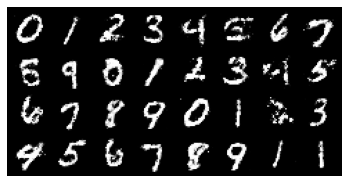

Epoch  91| generator loss: 0.64763971 discriminator loss: 1.27689458
Epoch  92| generator loss: 0.65023277 discriminator loss: 1.27670767
Epoch  93| generator loss: 0.65040916 discriminator loss: 1.28447453
Epoch  94| generator loss: 0.64683649 discriminator loss: 1.27924008
Epoch  95| generator loss: 0.65146492 discriminator loss: 1.27917237
Epoch  96| generator loss: 0.65505523 discriminator loss: 1.29427100
Epoch  97| generator loss: 0.64867703 discriminator loss: 1.29371367
Epoch  98| generator loss: 0.64859658 discriminator loss: 1.29743834
Epoch  99| generator loss: 0.65036897 discriminator loss: 1.29213780
Epoch 100| generator loss: 0.64699444 discriminator loss: 1.29906869


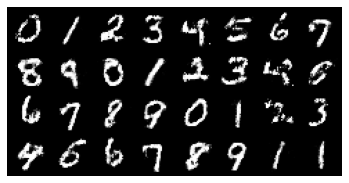

Epoch 101| generator loss: 0.64794301 discriminator loss: 1.28701840
Epoch 102| generator loss: 0.65074754 discriminator loss: 1.29300049
Epoch 103| generator loss: 0.64877850 discriminator loss: 1.29217897
Epoch 104| generator loss: 0.64884480 discriminator loss: 1.29562360
Epoch 105| generator loss: 0.64921751 discriminator loss: 1.28096316
Epoch 106| generator loss: 0.64871821 discriminator loss: 1.29705521
Epoch 107| generator loss: 0.64965489 discriminator loss: 1.29956528
Epoch 108| generator loss: 0.64389929 discriminator loss: 1.30040209
Epoch 109| generator loss: 0.65067096 discriminator loss: 1.29408457
Epoch 110| generator loss: 0.64635189 discriminator loss: 1.30554655


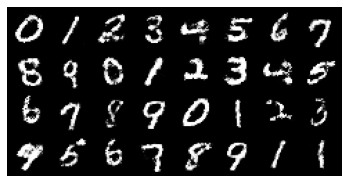

Epoch 111| generator loss: 0.64787139 discriminator loss: 1.29868152
Epoch 112| generator loss: 0.65101087 discriminator loss: 1.30229662
Epoch 113| generator loss: 0.64520042 discriminator loss: 1.30573571
Epoch 114| generator loss: 0.64714964 discriminator loss: 1.29871378
Epoch 115| generator loss: 0.64652464 discriminator loss: 1.30321541
Epoch 116| generator loss: 0.64918136 discriminator loss: 1.30416847
Epoch 117| generator loss: 0.64984970 discriminator loss: 1.30622195
Epoch 118| generator loss: 0.65121732 discriminator loss: 1.30674641
Epoch 119| generator loss: 0.64857865 discriminator loss: 1.31297762
Epoch 120| generator loss: 0.64778167 discriminator loss: 1.30352425


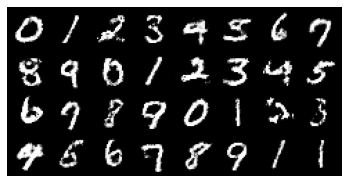

Epoch 121| generator loss: 0.64640631 discriminator loss: 1.30366976
Epoch 122| generator loss: 0.64570178 discriminator loss: 1.29772469
Epoch 123| generator loss: 0.64952169 discriminator loss: 1.31349544
Epoch 124| generator loss: 0.64919976 discriminator loss: 1.30675217
Epoch 125| generator loss: 0.64948693 discriminator loss: 1.30508081
Epoch 126| generator loss: 0.64803507 discriminator loss: 1.31228997
Epoch 127| generator loss: 0.64796246 discriminator loss: 1.30122236
Epoch 128| generator loss: 0.65008512 discriminator loss: 1.30690402
Epoch 129| generator loss: 0.64620908 discriminator loss: 1.30444576
Epoch 130| generator loss: 0.65027590 discriminator loss: 1.31115181


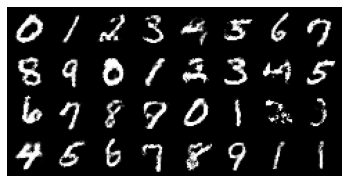

Epoch 131| generator loss: 0.65063159 discriminator loss: 1.30969003
Epoch 132| generator loss: 0.64922260 discriminator loss: 1.30856225
Epoch 133| generator loss: 0.64802387 discriminator loss: 1.30688283
Epoch 134| generator loss: 0.64443615 discriminator loss: 1.30751751
Epoch 135| generator loss: 0.64788319 discriminator loss: 1.31165301
Epoch 136| generator loss: 0.64889001 discriminator loss: 1.30718815
Epoch 137| generator loss: 0.64591945 discriminator loss: 1.30957153
Epoch 138| generator loss: 0.64569754 discriminator loss: 1.30829795
Epoch 139| generator loss: 0.64689692 discriminator loss: 1.30747657
Epoch 140| generator loss: 0.64741147 discriminator loss: 1.30932646


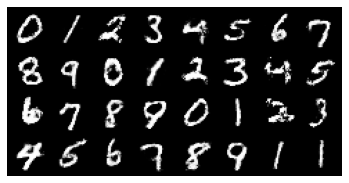

Epoch 141| generator loss: 0.65063646 discriminator loss: 1.30928056
Epoch 142| generator loss: 0.65175810 discriminator loss: 1.31376856
Epoch 143| generator loss: 0.64721045 discriminator loss: 1.31318093
Epoch 144| generator loss: 0.64667595 discriminator loss: 1.31068155
Epoch 145| generator loss: 0.64836205 discriminator loss: 1.31409424
Epoch 146| generator loss: 0.64842241 discriminator loss: 1.31418358
Epoch 147| generator loss: 0.64484815 discriminator loss: 1.31097913
Epoch 148| generator loss: 0.64734090 discriminator loss: 1.31684164
Epoch 149| generator loss: 0.64885223 discriminator loss: 1.31055300
Epoch 150| generator loss: 0.64784477 discriminator loss: 1.31000066


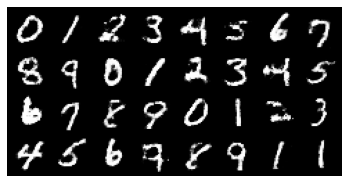

Epoch 151| generator loss: 0.64837606 discriminator loss: 1.31257648
Epoch 152| generator loss: 0.64717835 discriminator loss: 1.31210181
Epoch 153| generator loss: 0.65036013 discriminator loss: 1.31455087
Epoch 154| generator loss: 0.64672169 discriminator loss: 1.31092207
Epoch 155| generator loss: 0.64753175 discriminator loss: 1.31168441
Epoch 156| generator loss: 0.64694970 discriminator loss: 1.31943576
Epoch 157| generator loss: 0.64562607 discriminator loss: 1.31234655
Epoch 158| generator loss: 0.65017839 discriminator loss: 1.31639130
Epoch 159| generator loss: 0.64827390 discriminator loss: 1.31488025
Epoch 160| generator loss: 0.64799056 discriminator loss: 1.31256522


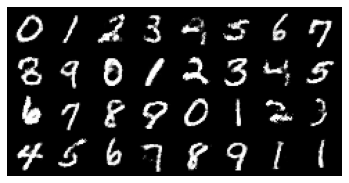

Epoch 161| generator loss: 0.64505936 discriminator loss: 1.31524951
Epoch 162| generator loss: 0.64620964 discriminator loss: 1.31848190
Epoch 163| generator loss: 0.64724672 discriminator loss: 1.31454436
Epoch 164| generator loss: 0.64496806 discriminator loss: 1.31470608
Epoch 165| generator loss: 0.64650732 discriminator loss: 1.31708432
Epoch 166| generator loss: 0.64808105 discriminator loss: 1.31807755
Epoch 167| generator loss: 0.64714509 discriminator loss: 1.31295832
Epoch 168| generator loss: 0.64821627 discriminator loss: 1.31549904
Epoch 169| generator loss: 0.64743639 discriminator loss: 1.32039518
Epoch 170| generator loss: 0.64748367 discriminator loss: 1.31551723


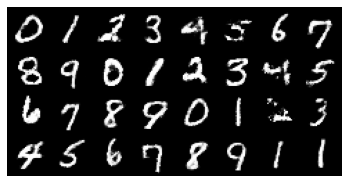

Epoch 171| generator loss: 0.64631312 discriminator loss: 1.31749708
Epoch 172| generator loss: 0.64647810 discriminator loss: 1.31769174
Epoch 173| generator loss: 0.64534652 discriminator loss: 1.31681071
Epoch 174| generator loss: 0.64534335 discriminator loss: 1.32008528
Epoch 175| generator loss: 0.64459193 discriminator loss: 1.31435045
Epoch 176| generator loss: 0.64866242 discriminator loss: 1.31943897
Epoch 177| generator loss: 0.64492933 discriminator loss: 1.31511330
Epoch 178| generator loss: 0.64669519 discriminator loss: 1.31808894
Epoch 179| generator loss: 0.64613385 discriminator loss: 1.31596615
Epoch 180| generator loss: 0.64844194 discriminator loss: 1.32005504


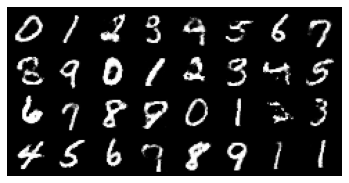

Epoch 181| generator loss: 0.64637206 discriminator loss: 1.31280773
Epoch 182| generator loss: 0.64633916 discriminator loss: 1.31500451
Epoch 183| generator loss: 0.64563896 discriminator loss: 1.31625408
Epoch 184| generator loss: 0.64508160 discriminator loss: 1.31859912
Epoch 185| generator loss: 0.64627743 discriminator loss: 1.31457102
Epoch 186| generator loss: 0.64346759 discriminator loss: 1.31738915
Epoch 187| generator loss: 0.64418508 discriminator loss: 1.31314444
Epoch 188| generator loss: 0.64493605 discriminator loss: 1.31487662
Epoch 189| generator loss: 0.64717856 discriminator loss: 1.31589403
Epoch 190| generator loss: 0.64561951 discriminator loss: 1.31721877


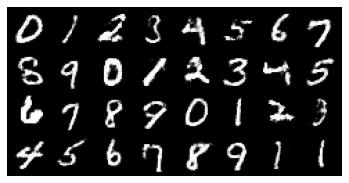

Epoch 191| generator loss: 0.64522539 discriminator loss: 1.31418109
Epoch 192| generator loss: 0.64503369 discriminator loss: 1.31640965
Epoch 193| generator loss: 0.64478852 discriminator loss: 1.31622955
Epoch 194| generator loss: 0.64641325 discriminator loss: 1.31975486
Epoch 195| generator loss: 0.64554008 discriminator loss: 1.31244175
Epoch 196| generator loss: 0.64512537 discriminator loss: 1.31517910
Epoch 197| generator loss: 0.64623497 discriminator loss: 1.31266637
Epoch 198| generator loss: 0.64447855 discriminator loss: 1.31341944
Epoch 199| generator loss: 0.64596814 discriminator loss: 1.31235181
Epoch 200| generator loss: 0.64460680 discriminator loss: 1.31468645


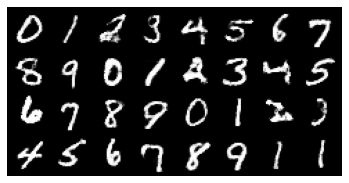

Epoch 201| generator loss: 0.64620613 discriminator loss: 1.31545830
Epoch 202| generator loss: 0.64440238 discriminator loss: 1.31286835
Epoch 203| generator loss: 0.64443415 discriminator loss: 1.31739390
Epoch 204| generator loss: 0.64447816 discriminator loss: 1.31399714
Epoch 205| generator loss: 0.64570257 discriminator loss: 1.31338926
Epoch 206| generator loss: 0.64410605 discriminator loss: 1.31496271
Epoch 207| generator loss: 0.64342816 discriminator loss: 1.31219995
Epoch 208| generator loss: 0.64530980 discriminator loss: 1.31544338
Epoch 209| generator loss: 0.64501052 discriminator loss: 1.31433822
Epoch 210| generator loss: 0.64452593 discriminator loss: 1.31309935


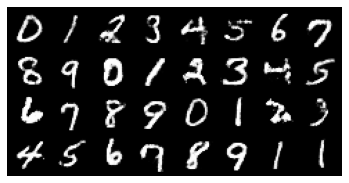

Epoch 211| generator loss: 0.64626857 discriminator loss: 1.31205262
Epoch 212| generator loss: 0.64388665 discriminator loss: 1.31205057
Epoch 213| generator loss: 0.64785509 discriminator loss: 1.31338109
Epoch 214| generator loss: 0.64525941 discriminator loss: 1.31524109
Epoch 215| generator loss: 0.64436301 discriminator loss: 1.31026029
Epoch 216| generator loss: 0.64565556 discriminator loss: 1.31447764
Epoch 217| generator loss: 0.64414341 discriminator loss: 1.31174670
Epoch 218| generator loss: 0.64515205 discriminator loss: 1.31453814
Epoch 219| generator loss: 0.64375547 discriminator loss: 1.30661147
Epoch 220| generator loss: 0.64637285 discriminator loss: 1.31265514


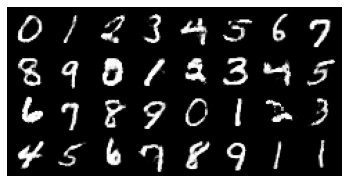

Epoch 221| generator loss: 0.64493441 discriminator loss: 1.31186091
Epoch 222| generator loss: 0.64283667 discriminator loss: 1.31070240
Epoch 223| generator loss: 0.64373703 discriminator loss: 1.30950921
Epoch 224| generator loss: 0.64360733 discriminator loss: 1.31191204
Epoch 225| generator loss: 0.64388831 discriminator loss: 1.31202819
Epoch 226| generator loss: 0.64390241 discriminator loss: 1.31335121
Epoch 227| generator loss: 0.64453536 discriminator loss: 1.31179526
Epoch 228| generator loss: 0.64248410 discriminator loss: 1.31173154
Epoch 229| generator loss: 0.64330631 discriminator loss: 1.31075430
Epoch 230| generator loss: 0.64519291 discriminator loss: 1.30946649


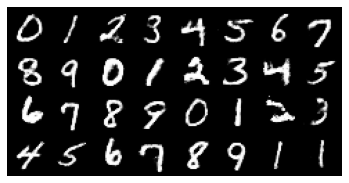

Epoch 231| generator loss: 0.64354401 discriminator loss: 1.31321246
Epoch 232| generator loss: 0.64263204 discriminator loss: 1.31126128
Epoch 233| generator loss: 0.64451005 discriminator loss: 1.30959337
Epoch 234| generator loss: 0.64181763 discriminator loss: 1.31029426
Epoch 235| generator loss: 0.64308360 discriminator loss: 1.30971206
Epoch 236| generator loss: 0.64381555 discriminator loss: 1.31115745
Epoch 237| generator loss: 0.64448883 discriminator loss: 1.30687396
Epoch 238| generator loss: 0.64337764 discriminator loss: 1.31450601
Epoch 239| generator loss: 0.64409086 discriminator loss: 1.30908411
Epoch 240| generator loss: 0.64167780 discriminator loss: 1.30962710


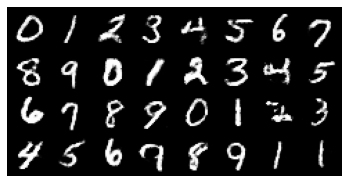

Epoch 241| generator loss: 0.64225913 discriminator loss: 1.30739058
Epoch 242| generator loss: 0.64263797 discriminator loss: 1.30921722
Epoch 243| generator loss: 0.64275153 discriminator loss: 1.30900746
Epoch 244| generator loss: 0.64235486 discriminator loss: 1.30697942
Epoch 245| generator loss: 0.64400840 discriminator loss: 1.30792276
Epoch 246| generator loss: 0.64324505 discriminator loss: 1.30718096
Epoch 247| generator loss: 0.64272648 discriminator loss: 1.31088012
Epoch 248| generator loss: 0.64355948 discriminator loss: 1.31102916
Epoch 249| generator loss: 0.64276073 discriminator loss: 1.30658549
Epoch 250| generator loss: 0.64309993 discriminator loss: 1.31023654


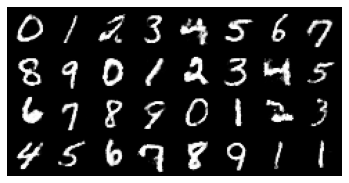

In [14]:
num_epochs = 250
k = 1
test_noise = torch.randn(32, 128).to(device)
test_condition = torch.Tensor(list(range(10)) * 3 + [1, 1]).long().to(device)

generator.train()
discriminator.train()
g_losses, d_losses = [], []
for epoch in range(num_epochs):
    g_loss, d_loss = 0.0, 0.0
    for i, (imgs, labels) in enumerate(dataloader):
        real_data = imgs.to(device)
        real_condition = labels.to(device)
        for j in range(k):
            fake_condition = torch.randint(0, 10, size=(real_condition.size(0),), device=device)
            fake_data = generator(torch.randn(imgs.size(0), 128, device=device), fake_condition).detach()
            d_loss += train_discriminator(discriminator, criterion, disc_optim, real_data, real_condition, fake_data, fake_condition)
        
        fake_condition = torch.randint(0, 10, size=(real_condition.size(0),), device=device)
        fake_data = generator(torch.randn(imgs.size(0), 128, device=device), fake_condition)
        g_loss += train_generator(discriminator, criterion, gen_optim, fake_data, fake_condition)

    g_losses.append(g_loss / i)
    d_losses.append(d_loss / i)
    print("Epoch {:3d}| generator loss: {:.8f} discriminator loss: {:.8f}".format(epoch + 1, g_loss / i, d_loss / i))
    
    if (epoch + 1) % 10 == 0:
        img = generator(test_noise, test_condition).cpu().detach()
        img = make_grid(img).permute(1, 2, 0)
        
        plt.imshow(img)
        plt.axis("off")
        plt.show()

## [Deep Convolutional GAN (DCGAN)](https://arxiv.org/abs/1511.06434v2)

<center><img src="assets/dcgan.png" width=50%></center>

### New features:

1. **Згорткова архітектура:** Традиційні GAN використовували повністю зв’язані рівні, але DCGAN пропонувало використовувати згорточні рівні як для генератора, так і для дискримінатора. Це зробило DCGAN особливо придатним для таких завдань, як створення зображень.
2. **Рекомендації щодо архітектури:** У статті запропоновано конкретні рекомендації щодо архітектури для стабільних глобальних мереж глибокої згортки:
     — Використовуйте поступові згортки замість об’єднання для зменшення роздільності зображень.
     - Використовуйте пакетну нормалізацію як у генераторі, так і в дискримінаторі.
     - Видаліть повністю підключені приховані шари для більш глибоких архітектур.
     - Для генератора використовуйте активацію ReLU для всіх рівнів, крім вихідного рівня, який використовує Tanh.
     - Для дискримінатора використовуйте активацію LeakyReLU.
3. **Візуальна перевірка внутрішніх рівнів:** Стаття надає розуміння, візуалізуючи фільтри та проміжні активації GAN, допомагаючи зрозуміти, що вивчає мережа.
4. **Якість створеного зображення:** DCGAN могли генерувати зображення значно вищої якості, ніж попередні версії GAN. Документ демонстрував зображення, створені з випадкових векторів шуму, і результати були візуально привабливими та демонстрували різноманітні та реалістичні зображення.
5. **Навчання функцій і семантична векторна арифметика:** Стаття показала, що латентний простір мав цікаві структури. Виконуючи арифметику в латентному просторі, вони змогли продемонструвати такі поняття, як «людина в окулярах» мінус «людина без окулярів» дорівнює «окулярам».
6. **Застосування, окрім зображень:** Хоча основним фокусом було створення зображень, у статті також показано, що DCGAN можна використовувати для інших завдань.
7. **Стабільність навчання:** Одним із значних внесків DCGAN була його стабільність під час навчання. GAN сумно відомі тим, що їх важко навчити, але архітектурний вибір DCGAN зробив його більш стабільним, ніж його попередники.

По суті, документ DCGAN став значним кроком вперед у світі генеративних моделей, зокрема у створенні високоякісних зображень. Архітектурні інновації та рекомендації щодо навчання, встановлені DCGAN, вплинули на багато подальших робіт у сфері GAN.

**[Official PyTorch DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).**

### [CycleGAN](https://arxiv.org/abs/1703.10593v7)

**CycleGAN** — це дуже популярна архітектура GAN, яка в основному використовується для вивчення трансформації між зображеннями різних стилів.

Як приклад:
- картинка між художніми та реалістичними зображеннями,
- трансформація між зображеннями коня та зебри,
- трансформація зимового образу в літній
- і так далі

FaceApp є одним із найпопулярніших прикладів CycleGAN, де людські обличчя трансформуються в різні вікові групи.

Як приклад, скажімо, X — це набір зображень коня, а Y — набір зображень зебри.


Мета полягає в тому, щоб вивчити функцію відображення $G: X \rightarrow Y$ так, щоб зображення, створені $G(X)$, не відрізнялися від зображення Y.<br>
Ця мета досягається за допомогою змагальної втрати. <br>
Це формулювання не лише вивчає $G$, але також вивчає функцію зворотного відображення $F: Y \rightarrow X$ і використовує втрату узгодженості циклу, щоб забезпечити виконання $F(G(X)) = X$ і навпаки.


Під час навчання 2 види тренувальних спостережень даються як вихідні дані.
- Один набір спостережень містить парні зображення ${X_i, Y_i}$ для $i$, де кожен $X_i$ має свій аналог $Y_i$.
- Інший набір спостережень містить набір зображень із $X$ та інший набір зображень із $Y$ без жодного збігу між $X_i$ та $Y_i$.

<center><img src="assets/cyclegan_training.webp"></center>

Є 2 типи функцій, які вивчаються, одна з них — $G$, яка перетворює $X$ на $Y$, а інша — $F$, яка перетворює $Y$ на $X$, і складається з двох окремих моделей GAN. Отже, ви знайдете 2 функції дискримінатора $D_x$, $D_y$.

Як частина формулювання змагальності існує один дискримінатор $D_x$, який класифікує, чи перетворений $Y$ не відрізняється від $Y$. Подібним чином існує ще один дискримінатор $D_y$, який класифікує, чи перетворений $X$ не відрізняється від $X$.

Разом із Adversarial Loss, CycleGAN використовує втрату узгодженості циклу, щоб забезпечити навчання без парних зображень, і ця додаткова втрата допомагає моделі мінімізувати втрати при реконструкції $F(G(x)) \approx X$ and $G(F(Y)) \approx Y$

Загальна формула CycleGAN складається з 3 окремих втрат, а саме:

$$ L(G, F, D_x, D_y) =  L_{\textit{GAN}} (G, D_y, X, Y) + L_{\textit{GAN}}(F, D_x, Y, X) + \lambda L_{cyc}(G, F) $$

де

$$ L_{\textit{GAN}}(G, D_y, X, Y) = \mathbb{E}_{y \sim p_{\textit{data}}(y)} \big [ \log D_y(y) \big ] + \mathbb{E}_{x \sim p_{\textit{data}}(x)} \big [ \log (1 - D_y(G(x))) \big ], $$

$$ L_{cyc}(G, F) = \mathbb{E}_{x \sim p_{\textit{data}}(x)} \big [ \lVert F(G(x)) - x \rVert_1 \big ] + \mathbb{E}_{y \sim p_{\textit{data}}(y)} \big [ \lVert G(F(y)) - y \rVert_1 \big ] $$

і в рамках оптимізації оптимізується наступна функція втрат.

$$ G^*, F^* = \arg \underset{G, F}{\min} \underset{D_x, D_y}{\max} L(G, F, D_x, D_y)$$

Ось приклад роботи CycleGan:

<center><img src="assets/cycle_gan_examples.jpeg" height=30%></center>

Функція втрат має вигляд:

```python
# Generator G translates X -> Y
# Generator F translates Y -> X.
fake_y = generator_g(real_x, training=True)
cycled_x = generator_f(fake_y, training=True)

fake_x = generator_f(real_y, training=True)
cycled_y = generator_g(fake_x, training=True)

# same_x and same_y are used for identity loss.
same_x = generator_f(real_x, training=True)
same_y = generator_g(real_y, training=True)

disc_real_x = discriminator_x(real_x, training=True)
disc_real_y = discriminator_y(real_y, training=True)

disc_fake_x = discriminator_x(fake_x, training=True)
disc_fake_y = discriminator_y(fake_y, training=True)

# calculate the loss
gen_g_loss = generator_loss(disc_fake_y)
gen_f_loss = generator_loss(disc_fake_x)

total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y,cycled_y)

# Total generator loss = adversarial loss + cycle loss
total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
```
<br><br>

**[Here is a good implementation of CycleGAN](https://github.com/Lornatang/CycleGAN-PyTorch).**

## [GAN-TTS](https://arxiv.org/abs/1909.11646v2)

**GAN-TTS** — це генеративна конкурентна мережа для синтезу тексту в мову. Архітектура складається з умовного генератора прямого зв’язку, який виробляє необроблене аудіо мовлення, і ансамблю дискримінаторів, які працюють у випадкових вікнах різного розміру. Дискримінатори аналізують аудіо як з точки зору загальної реалістичності, так і наскільки добре аудіо відповідає висловлюванню, яке має бути вимовлено.

<center><img src="assets/gan_tts.png" width=60%></center>

Архітектура генератора складається з кількох блоків, які є залишковими (розширеними) блоками згортки. Блоки поступово підвищують дискретизацію тимчасового розміру прихованих представлень, тоді як кількість каналів зменшується за допомогою блоків. Останній згортковий шар із активацією tanh створює одноканальний звуковий сигнал.

<center><img src="assets/gan_tts_blocks.jpg" width=60%></center>

Замість одного дискримінатора GAN-TTS використовує ансамбль дискримінаторів випадкового вікна (RWD), які працюють на фрагментах випадкової підвибірки реальних або згенерованих вибірок. Ансамбль дозволяє оцінювати аудіо різними способами, що доповнюють один одного.

**[Very good unofficial PyTorch implementation](https://github.com/yanggeng1995/GAN-TTS).**

## [StyleGAN](https://arxiv.org/abs/1812.04948)

StyleGAN — це форма GAN, яка здатна генерувати зображення з дуже високою роздільною здатністю навіть із роздільною здатністю $1024 \times 1024$. Ідея полягає в тому, щоб побудувати стек шарів, де початкові шари здатні генерувати зображення з низькою роздільною здатністю (починаючи з $2 \times 2$), а наступні шари поступово збільшують роздільну здатність.

Найпростіший спосіб для GAN генерувати зображення з високою роздільною здатністю — це запам’ятовувати зображення з навчального набору даних, а під час створення нових зображень він може додавати випадковий шум до наявного зображення. Насправді StyleGAN цього не робить, а вивчає особливості людського обличчя та створює новий образ людського обличчя, якого не існує в реальності. Якщо це звучить цікаво, відвідайте **https://thispersondoesnotexist.com/** Кожне відвідування цієї URL-адреси створюватиме нове зображення людського обличчя, якого немає у Всесвіті.

<center><img src="assets/stylegan.png"></center>

Цей малюнок зображує типову архітектуру StyleGAN. Вектор латентного простору $z$ проходить через перетворення відображення, що складається з 8 повністю зв’язаних шарів, тоді як мережа синтезу складається з 18 шарів, де кожен шар створює зображення від $4 \times 4$ до $1024 \times 1024$. Вихідний шар виводить зображення RGB через окремий шар згортки. Ця архітектура має 26,2 мільйона параметрів, і через таку велику кількість параметрів, які можна навчати, ця модель вимагає величезної кількості навчальних зображень для створення успішної моделі.

Кожен шар нормалізується за допомогою функції адаптивної нормалізації екземпляра (AdaIN):

$$ \operatorname{AdaIN}(x_i, y) = y_{s,i} \frac{x_i - \mu(x_i)}{\sigma(x_i)} + y_{b,i} $$

де кожна карта ознак $x_i$ нормалізується окремо, а потім масштабується та зміщується за допомогою відповідних скалярних компонентів зі стилю y. Таким чином, розмірність y вдвічі перевищує кількість карт ознак на цьому латенті.

**[Unofficial PyTorch implementation](https://github.com/huangzh13/StyleGAN.pytorch).**

## [DALL-E](https://arxiv.org/abs/2204.06125)


Документ DALL-E (перша версія) під назвою «Hierarchical Text-Conditional Image Generation with CLIP Latents» був опублікований у 2021 році OpenAI. Він представив нову модель генерації зображень із текстових описів, яка давала більш реалістичні та детальні результати, ніж попередні моделі.

Модель DALL-E базується на двох ключових компонентах:
- Кодер трансформера, який використовується для кодування текстового опису в приховане представлення.
- Дифузійний декодер, який використовується для генерації зображення з прихованого представлення.

Кодер трансформера навчається за допомогою підходу до навчання під наглядом на наборі даних текстових описів і парних зображень. Декодер дифузії навчається за допомогою підходу до навчання з підкріпленням, коли він отримує винагороду за створення зображень, які є реалістичними та відповідають текстовому опису.

Коли модель навчена, її можна використовувати для створення зображень із нових текстових описів, виконавши такі кроки:

1. Текстовий опис кодується в латентне представлення за допомогою трансформера енкодера.
2. Приховане представлення передається в дифузійний декодер, який генерує зображення.
3. Зображення проходить постобробку для підвищення його якості та реалістичності.

Модель DALL-E була навчена на наборі даних із 128 мільйонів пар текст-зображення, і вона змогла створити зображення, які в деяких випадках було неможливо відрізнити від реальних фотографій.

Ось приклад текстового опису та відповідного зображення, згенерованого DALL-E:

<div class="alert alert-block alert-info">
<center>
    <b>Фотореалістична картина кота, який сидить на коричневому дивані та дивиться в камеру.</b><br>
    <img src="assets/dall-e_sample.jpeg">
</center>
</div>

Модель DALL-E має багато потенційних застосувань, наприклад:

- Створення нових креативних зображень для використання в мистецтві, дизайні та рекламі.
- Створення реалістичних зображень для використання у відеоіграх і симуляторах.
- Допомога людям з вадами зору у візуалізації навколишнього світу.

Загалом модель DALL-E є значним проривом у сфері генерації тексту в зображення. Він здатний генерувати реалістичні та детальні зображення з текстових описів, що має потенціал для революції в багатьох галузях промисловості.

**[PyTorch implementation](https://github.com/lucidrains/DALLE-pytorch).**

## [ImaGen](https://arxiv.org/abs/2205.11487)

**[Demo](https://imagen.research.google/).**

Стаття Imagen представила кілька нових методів, які покращили сучасні моделі дифузії тексту в зображення. Ці методи включали:

- Використання готових енкодерів тексту: Imagen використовує великий попередньо навчений енкодер тексту, щоб кодувати текстовий опис у приховане представлення. Це на відміну від попередніх моделей, які зазвичай використовували спеціальні текстові кодувальники, навчені на наборі даних із зображенням тексту.
- Масштабування розміру текстового кодувальника: Imagen показав, що масштабування розміру текстового кодувальника важливіше, ніж масштабування розміру моделі дифузії. Це пояснюється тим, що кодувальник тексту відповідає за розуміння семантики текстового опису, що є більш складним завданням, ніж генерування самого зображення.
- Представлення нового порогового дифузійного семплера: Imagen представляє новий пороговий дифузійний семплер, який дозволяє використовувати дуже великі керівні ваги без класифікатора. Це покращує якість створюваних зображень, особливо для складних текстових описів.
- Представляємо нову архітектуру Efficient U-Net: Imagen представляє нову архітектуру Efficient U-Net, яка є більш ефективною для обчислень, пам’яті та швидше конвергує, ніж попередні архітектури.

<center><img src="assets/imagen_pipeline.png"></center>

1. Спочатку заголовок вводиться в **кодер тексту**. Цей кодер перетворює текстовий підпис у числове представлення, яке **інкапсулює семантичну інформацію в тексті**.
2. Далі модель генерації зображення створює зображення, починаючи з шуму, або «телевізійної статики», і повільно перетворює його на вихідне зображення. Щоб керувати цим процесом, модель генерації зображення отримує кодування тексту як вхідні дані, що має ефект **повідомлення моделі, що міститься в підписі**, щоб вона могла створити відповідне зображення. На виході буде маленьке зображення, яке візуально відображає заголовок, який ми вводимо в текстовий кодувальник.
3. Маленьке зображення потім передається в **модель супер-роздільності**, яка збільшує зображення до вищої роздільної здатності. Ця модель також приймає кодування тексту як вхідні дані, що допомагає моделі вирішити, як поводитися, коли вона «заповнює прогалини» відсутньої інформації, які обов’язково виникають через збільшення розміру нашого зображення в чотири рази. Результатом є **зображення середнього розміру** того, що ми хочемо.
4. Зрештою, це зображення середнього розміру потім передається в **іншу модель із супер-роздільністю**, яка працює майже ідентично попередній, за винятком того, що цього разу воно бере наше зображення середнього розміру та збільшує його до **високого -роздільна здатність** зображення. Результатом є піксельне зображення розміром $1024 \times 1024$, яке візуально відображає семантику нашого підпису.

На додаток до покращеної якості зображення, Imagen також може створювати зображення, які більше відповідають текстовому опису, ніж попередні моделі. Наприклад, Imagen може створювати зображення, які містять кілька об’єктів, об’єкти в різних позах і об’єкти з різними текстурами.

Загалом стаття Imagen є значним проривом у галузі моделей дифузії тексту до зображення. Imagen здатний створювати реалістичні та детальні зображення з текстових описів, що має потенціал для революції в багатьох галузях промисловості.

**[PyTorch implementation](https://github.com/lucidrains/imagen-pytorch).**

## Latent Diffusion Models

Стаття «High-Resolution Image Synthesis with Latent Diffusion Models» (LDM) представила кілька нових методів, які вдосконалили сучасні моделі дифузії тексту в зображення, особливо для синтезу зображень високої роздільної здатності. Ці методи включали:

- **Використання прихованої дифузії:** LDM працюють у прихованому просторі, який є стислим представленням простору зображення. Це дає змогу навчати та генерувати зображення високої роздільної здатності, не вимагаючи надмірних обчислювальних ресурсів.
- **Використання шарів перехресної уваги:** LDM використовують шари перехресної уваги, щоб дозволити моделі дифузії звертати увагу на текстовий опис під час створення зображення. Це покращує якість і послідовність створених зображень.
- **Представлено нову архітектуру прихованої дифузії:** LDM представляє нову архітектуру прихованої дифузії, яка є більш ефективною та масштабованою, ніж попередні архітектури. Це дає змогу навчати LDM на більших наборах даних і створювати зображення з вищою роздільною здатністю.

Завдяки цим методам LDM досягли нових найсучасніших результатів у кількох задачах синтезу зображень, зокрема:

- **Створення високоякісних зображень:** LDM створювали високоякісні зображення, такі як пейзажі та портрети, які в деяких випадках було неможливо відрізнити від реальних фотографій.
- **Синтез тексту в зображення:** LDM генерували зображення з текстових описів, які були більш реалістичними та детальними, ніж попередні моделі.
- **Домальовування зображення:** LDM зафарбовували відсутні області на зображеннях із високою якістю.
- **Суперроздільна здатність:** LDM підвищують масштаб зображень із низькою роздільною здатністю до зображень із високою без втрати деталей.

Загалом стаття LDMs є значним проривом у галузі моделей дифузії тексту до зображення. LDM здатні генерувати високоякісні та реалістичні зображення з текстових описів, що має потенціал для революції в багатьох галузях промисловості.

Окрім згаданих вище вдосконалень, LDM також мають кілька інших переваг порівняно з попередніми моделями дифузії:

- LDM більш ефективні для навчання та створення зображень, особливо для зображень з високою роздільною здатністю.
- LDM є більш гнучкими і можуть використовуватися для різноманітних завдань синтезу зображень, включаючи генерацію зображень, синтез тексту до зображення, малювання зображень і супер-роздільність.
- LDM легше контролювати, і ними можна керувати для створення зображень із певними властивостями, такими як певний стиль або колірна палітра.

Загалом LDM є новим потужним інструментом для синтезу зображень і мають потенціал революціонізувати багато різних галузей, таких як мистецтво, дизайн і створення медіа.

### How it works

LDM працюють, поступово додаючи шум до прихованого представлення зображення, а потім змінюючи процес, щоб створити зображення. Приховане представлення — це стисне представлення простору зображення, яке дає змогу навчати та генерувати зображення високої роздільної здатності, не вимагаючи надмірних обчислювальних ресурсів.

<center><img src="assets/diffusion_forward.png"></center>

LDM навчаються з використанням підходу до навчання під наглядом. Під час навчання моделі надається набір навчальних зображень та їхні відповідні приховані представлення. Модель вчиться змінювати процес дифузії, щоб генерувати зображення з прихованого представлення.

<center><img src="assets/diffusion_reversed.png"></center>

Коли модель навчена, її можна використовувати для створення зображень із текстових описів, виконавши такі кроки:

1. Текстовий опис кодується в приховане представлення за допомогою текстового кодувальника.
2. Приховане представлення передається в LDM, який генерує зображення.
3. Зображення проходить постобробку для підвищення його якості та реалістичності.

LDM використовують шари перехресної уваги, щоб дозволити дифузійній моделі звертати увагу на текстовий опис під час генерації зображення. Це покращує якість і послідовність створених зображень.

LDM мають кілька переваг перед попередніми моделями дифузії:
- LDM більш ефективні для навчання та створення зображень, особливо для зображень з високою роздільною здатністю.
- LDM є більш гнучкими і можуть використовуватися для різноманітних завдань синтезу зображень, включаючи генерацію безумовних зображень, синтез тексту до зображення, малювання зображень і супер-роздільність.
- LDM легше контролювати, і ними можна керувати для створення зображень із певними властивостями, такими як певний стиль або колірна палітра.


## [ControlNet](https://arxiv.org/abs/2302.05543)

Документ ControlNet представив нову архітектуру нейронної мережі, яка дозволяє користувачам контролювати вихід дифузійних моделей, надаючи додаткові умови. Це на відміну від попередніх дифузійних моделей, які зазвичай могли генерувати зображення лише з текстових описів.

ControlNet працює, обумовлюючи модель дифузії різними типами даних, наприклад:
- **Карти країв:** ControlNet можна використовувати для створення зображень, які відповідають певній карті країв. Це може бути корисним для створення зображень об’єктів або сцен із певними формами чи контурами.
- **Карти глибини:** ControlNet можна використовувати для створення зображень із певною картою глибини. Це може бути корисним для створення зображень 3D-сцен або об’єктів.
- **Маски сегментації:** ControlNet можна використовувати для створення зображень, які сегментують різні об’єкти на сцені. Це може бути корисним для створення зображень із певними об’єктами чи фоном.

ControlNet дозволяє користувачам створювати зображення з високим рівнем контролю над своїм виглядом.

У документі ControlNet показано, що ControlNet можна використовувати для покращення якості та узгодженості зображень, створених дифузійними моделями. Наприклад, ControlNet можна використовувати для створення зображень із певними об’єктами чи сценами або зображень із певними формами чи контурами.

ControlNet також має потенціал для використання для багатьох інших завдань, таких як:
- **Редагування зображень:** ControlNet можна використовувати для редагування зображень, додаючи або видаляючи об’єкти, змінюючи фон або регулюючи глибину різкості.
- **Відновлення зображень:** ControlNet можна використовувати для відновлення пошкоджених або неповних зображень.
- **Синтез зображень:** ControlNet можна використовувати для створення нових зображень із існуючих або з нуля.

### How it works

Повторюючи наведену вище просту структуру, ми можемо контролювати стабільну дифузію таким чином:

<center><img src="assets/controlnet.png"></center>

Таким чином ControlNet може **повторно використовувати** кодер SD як **глибоку, міцну, надійну та потужну основу** для вивчення різноманітних елементів керування. Багато доказів (наприклад, [це](https://vpd.ivg-research.xyz/) і [це](https://jerryxu.net/ODISE/)) підтверджують, що кодувальник SD є чудовою основою.

Зауважте, що спосіб з’єднання шарів ефективний з точки зору обчислень. Оригінальний SD-кодер не потребує зберігання градієнтів (заблокований оригінальний SD-кодер Block 1234 і Middle). Необхідна пам’ять GPU не набагато більша, ніж оригінальна SD, хоча додано багато шарів. Чудово!

**[PyTorch code](https://github.com/lllyasviel/ControlNet).**

## [FreeU: Free Lunch in Diffusion U-Net](https://chenyangsi.top/FreeU/)

Метод, який суттєво покращує якість зразка моделі дифузії без будь-яких витрат: без навчання, без введення додаткових параметрів і без збільшення пам’яті чи часу вибірки.

<center><img src="assets/freeu.jpg"></center>

SD використовує архітектуру UNet під капотом, де з’єднання пропуску маршрутизуються між блоками кодера та декодера. Характеристики, отримані на виході блоків декодера ("магістральні" функції) і характеристики, що надходять від з'єднання пропуску, об'єднуються та надсилаються до наступного блоку декодера. Автори помітили, що опорні функції вносять більший внесок саме в шумозаглушення і низькочастотні деталі (це груба структура об'єкта), а пропускні функції доповнюють генерацію високочастотної інформацією, допомагаючи відновити дрібні деталі картинки.

Автори зважили внесок основних і пропускаючих функцій під час логічного висновку, помноживши їх на два скаляри $b>1$ і $s<1$ відповідно. Тобто ми збільшили вагу основних функцій, щоб зробити акцент на глобальній структурі, і зменшили внесок пропускних функцій, щоб зменшити високочастотні артефакти. І це спрацювало як для фотографій, так і для відео!


<center><img src="assets/freeu_examples.jpg"></center>

**[PyTorch code](https://github.com/ChenyangSi/FreeU).**